## Import libraries

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import networkx as nx
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import os
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format  # Display only 2 decimal points
import csv
import json

# Load Sioux Falls Network

In [2]:
net= pd.read_csv('/scratch/gayathri.eee.nitt/sioux_falls/SiouxFalls_net.tntp', skiprows=8, sep='\t').drop(['~', ';'], axis =1)
net['edge']=net.index+1
net['length'] = net.length*5
flow=pd.read_csv('/scratch/gayathri.eee.nitt/sioux_falls/SiouxFalls_flow.tntp',sep='\t').drop(['From ', 'To '],axis=1)
flow.rename(columns={"Volume ": "flow", "Cost ": "cost"},inplace=True)
node_coord=pd.read_csv('/scratch/gayathri.eee.nitt/sioux_falls/SiouxFalls_node.tntp',sep='\t').drop([';'], axis=1) # Actual Sioux Falls coordinate
node_xy=pd.read_csv('/scratch/gayathri.eee.nitt/sioux_falls/SiouxFalls_node_xy.tntp',sep='\t') # X,Y position for good visualization

In [3]:
# dataframe containing all link attributes
sioux_falls_df=pd.concat([net,flow], axis=1)
sioux_falls_df

,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type,edge,flow,cost
0,1,2,"25,900.20",30,6,0.15,4,0,0,1,1,"4,494.66",6.00
1,1,3,"23,403.47",20,4,0.15,4,0,0,1,2,"8,119.08",4.01
2,2,1,"25,900.20",30,6,0.15,4,0,0,1,3,"4,519.08",6.00
3,2,6,"4,958.18",25,5,0.15,4,0,0,1,4,"5,967.34",6.57
4,3,1,"23,403.47",20,4,0.15,4,0,0,1,5,"8,094.66",4.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,23,22,"5,000.00",20,4,0.15,4,0,0,1,72,"9,626.21",12.24
72,23,24,"5,078.51",10,2,0.15,4,0,0,1,73,"7,902.98",3.76
73,24,13,"5,091.26",20,4,0.15,4,0,0,1,74,"11,112.39",17.62
74,24,21,"4,885.36",15,3,0.15,4,0,0,1,75,"10,259.52",11.75


In [4]:
def create_graph(sioux_falls_df):
    # Create graph

    G = nx.from_pandas_edgelist(sioux_falls_df, 'init_node', 'term_node',
                                 ['capacity', 'length', 'free_flow_time', 'b', 'power', 'speed',
                                  'toll', 'link_type', 'edge', 'flow', 'cost'],
                                 create_using=nx.MultiDiGraph())

    # Coordinate positions
    pos_coord = {i: (a, b) for i, a, b in zip(node_coord.Node, node_coord.X, node_coord.Y)}
    pos_xy = {i: (a, b) for i, a, b in zip(node_xy.Node, node_xy.X, node_xy.Y)}

    # Assign positions as attributes
    for n, p in pos_coord.items():
        G.nodes[n]['pos_coord'] = p

    for n, p in pos_xy.items():
        G.nodes[n]['pos_xy'] = p

    # Define charging stations
    charging_stations = {4, 7, 20}
    for n in G.nodes:
        G.nodes[n]['charging_station'] = n in charging_stations

    return G, pos_xy, charging_stations

In [5]:
def plot_graph(G, pos):
    plt.figure(figsize=(12, 12))

    # Define node colors
    node_colors = ['red' if G.nodes[n]['charging_station'] else 'blue' for n in G.nodes]

    # Draw graph
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color=node_colors,
                     arrows=True, arrowsize=20, node_size=800,
                     font_color='white', font_size=14)

    # Draw edge labels (weights)
    edge_labels = {(u, v): f"{d['length']:.2f}" for u, v, d in G.edges(data=True) if 'length' in d}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Legend
    plt.scatter([], [], c='red', label='Charging Station', s=200)
    plt.scatter([], [], c='blue', label='Regular Node', s=200)
    plt.legend(loc='upper right', fontsize=12)
    plt.title('Sioux Falls Network with Charging Stations', fontsize=20)

    # Save figure
    plt.savefig('/scratch/gayathri.eee.nitt/routing/DQN/Results/sioux-falls-network.png')
    plt.show()

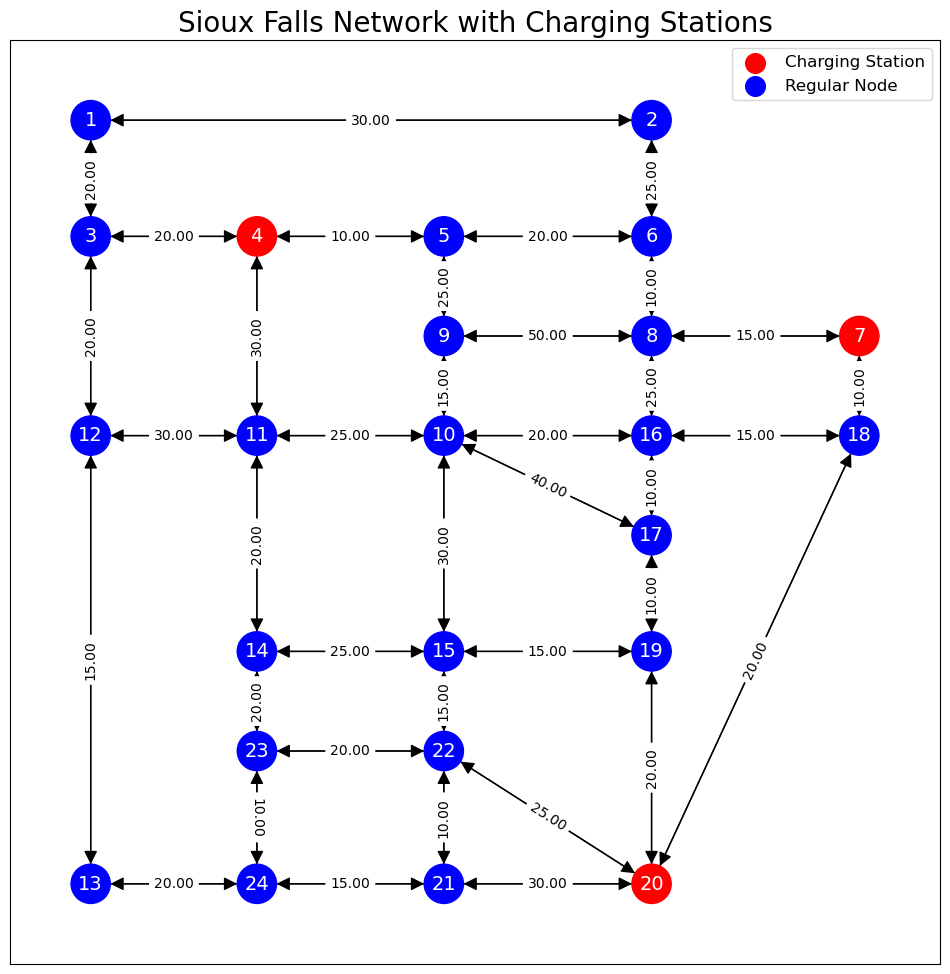

In [6]:
# Execution
G, pos,charging_stations = create_graph(sioux_falls_df)
plot_graph(G, pos)

## Pricing Game to find Nash equillibrium

In [7]:
def assign_vehicle_to_cs(cs_list, beta_1, beta_2):
  with open('/scratch/gayathri.eee.nitt/routing/EVData.csv', 'r') as file:
      csv_file = csv.reader(file)

      for vehicle_id, lines in enumerate(csv_file):
        start_point = int(lines[4])

        cs_keys = list(cs_list.keys())
        #print(cs_keys)

        softmax = np.zeros(len(cs_list))
        denominator = 0

        for cs in cs_keys:
          d = nx.shortest_path_length(G, source=start_point, target=cs, weight='length')
          #print(d)
          q = len(cs_list[cs])

          index = cs_keys.index(cs)
          num = np.exp(beta_1*d + beta_2*q)
          softmax[index] = num

        denominator = np.sum(softmax)  # Compute denominator for softmax

        softmax = softmax / denominator  # Normalize to get probabilities

        #print(softmax)
        charging_station = np.argmin(softmax)
        #print(charging_station)
        cs_list[cs_keys[charging_station]].append(vehicle_id)

        print("Vehicle {} starts at {} and the charging station is {}".format(vehicle_id, start_point, cs_keys[charging_station]))

  return cs_list

def calculate_waiting_time(charging_stations, rate_of_charge):
  waiting_time = {4: 0, 7: 0, 20: 0}

  with open('/scratch/gayathri.eee.nitt/routing/EVData.csv', 'r') as file:
      csv_file = csv.reader(file)
      for i, lines in enumerate(csv_file):
        vehicle_id = i
        energy_required = float(lines[2])*(float(lines[4])-float(lines[3]))
        time_required = energy_required/rate_of_charge

        for cs in charging_stations:
          if vehicle_id in charging_stations[cs]:
            waiting_time[cs] += time_required
            break

  for cs in waiting_time:
    waiting_time[cs] = waiting_time[cs]/len(charging_stations[cs])*60
  return waiting_time


In [8]:
charging_stations = {4: [], 7: [], 20: []}
beta_1 = 0.5
beta_2 = 0.5

charging_stations = assign_vehicle_to_cs(charging_stations, beta_1, beta_2)
waiting_time = calculate_waiting_time(charging_stations, 50)
print(waiting_time)

Vehicle 0 starts at 3 and the charging station is 4
Vehicle 1 starts at 5 and the charging station is 4
Vehicle 2 starts at 10 and the charging station is 7
Vehicle 3 starts at 8 and the charging station is 7
Vehicle 4 starts at 11 and the charging station is 4
Vehicle 5 starts at 19 and the charging station is 20
Vehicle 6 starts at 20 and the charging station is 20
Vehicle 7 starts at 24 and the charging station is 20
Vehicle 8 starts at 6 and the charging station is 7
Vehicle 9 starts at 1 and the charging station is 4
Vehicle 10 starts at 11 and the charging station is 4
Vehicle 11 starts at 13 and the charging station is 4
Vehicle 12 starts at 1 and the charging station is 4
Vehicle 13 starts at 5 and the charging station is 4
Vehicle 14 starts at 6 and the charging station is 7
Vehicle 15 starts at 8 and the charging station is 7
Vehicle 16 starts at 3 and the charging station is 4
Vehicle 17 starts at 4 and the charging station is 4
Vehicle 18 starts at 14 and the charging stati

In [9]:
from datetime import datetime
import random
import copy

In [10]:
import numpy as np

def energy_requirement_of_customers(final_SOC, initial_SOC, battery_capacity):
    """Function to calculate the energy requirement of the nth Electric Vehicle

    Args:
        final_SOC (np.ndarray): It is a numpy array of dimension (n,1) where the nth element of the array denotes the final SOC of the nth electric vehicle
        initial_SOC (np.ndarray): It is a numpy array of dimension (n,1) where the nth element of the array denotes the initial SOC of the nth electric vehicle
        battery_capacity (np.ndarray): It is a numpy array of dimension (n,1) where the nth element of the array denotes the battery capacity of the nth electric vehicle

    Returns:
        np.ndarray: It is a numpy array where the nth element denotes the energy requirement of the nth EV
    """
    return (final_SOC-initial_SOC)*battery_capacity

def profit_of_kth_station_at_time_t(lambda_sell, lambda_purchase, energy):
    """Calculate the profit of the kth charging station

    Args:
        lambda_sell (float): A floating point value that indicates the selling of electricity to the elctric vehicle at time t
        lambda_purchase (float): A floating point value that indicates the price at which electricity is purchased from the grid at time t
        energy (np.ndarray): This is a numpy array where the nth element denotes the energy supplied to the nth EV
    Returns:
        float: The profit earned by the kth charging station
    """
    profit = lambda_sell*energy - lambda_purchase*energy
    profit = np.sum(profit)

    return profit

def calculate_energy_n(lambda_max, lambda_sell_t, S):
    """_summary_

    Args:
        lambda_max (_type_): _description_
        lambda_sell_t (_type_): _description_
        S (_type_): _description_

    Returns:
        _type_: _description_
    """
    energy_n = np.divide((lambda_max - lambda_sell_t),S)
    return energy_n

def calculate_base_sensitivity(lambda_max, lambda_b, battery_capacity):
    S_b = np.divide((lambda_max-lambda_b),battery_capacity)
    return S_b

def calculate_alpha(lambda_sell, lambda_b, lambda_max):

    val = np.divide((lambda_sell-lambda_b),(lambda_max-lambda_b))
    n = np.shape(val)[0]
    temp = np.minimum((np.ones((n,1))-val),np.ones((n,1)))
    # print(np.shape(temp))
    alpha = np.maximum(temp,np.zeros((n,1)))
    return alpha

def calculate_behavioural_response(alpha, type_="high"):
    if type_ == "high":
        return (np.exp(alpha)-1)/(np.e - 1)
    if type_ == "medium":
        return alpha
    if type_ == "low":
        return np.log(alpha*(np.e-1)+1)

def calculate_utility(S, E_n_t, lambda_max, lambda_sell):
    """_summary_

    Args:
        S (_type_): _description_
        E_n_t (_type_): _description_
        lambda_max (_type_): _description_
        lambda_sell (_type_): _description_

    Returns:
        _type_: _description_
    """
    omega = -0.5*S*np.square(E_n_t) + (lambda_max-lambda_sell)*E_n_t
    return omega

In [11]:
def assign_vehicle_details(Cn, cs_sell_price, lambda_sell, initial_soc, final_soc, station, n):

    with open('/scratch/gayathri.eee.nitt/routing/EVData.csv', 'r') as file:
        csv_file = csv.reader(file)

        for i, lines in enumerate(csv_file):

            lambda_sell[i,station] = cs_sell_price

            Cn[i,station] = lines[1]

            initial_soc[i,station] = lines[2]

            final_soc[i,station] = lines[3]

In [12]:
def find_nash_equilibrium(grid_price, cs_sell_price, lambda_sell, lambda_purchase,
                          vehicles, stations, Cn, initial_soc, final_soc, E_n_t,
                          cs_sell_price_variation, lambda_max, lambda_b, omega_variation,
                          demand_variation, sensitivity_variation, profit_variation, delta_lambda = 2):

    prices = {4:0, 7:1, 20:2}

    for station in range(stations):
        prev_profit = 0
        cs_sell_price = grid_price

        print("The present station is {}".format(station))

        while True:
            cs_sell_price+=delta_lambda

            print("The present selling price is {}".format(cs_sell_price))

            assign_vehicle_details(Cn, cs_sell_price, lambda_sell, initial_soc, final_soc, station, n = vehicles)


            lambda_sell_append = copy.deepcopy(lambda_sell)

            cs_sell_price_variation.append(lambda_sell_append)

            S_b = calculate_base_sensitivity(lambda_max[:, station:station+1], lambda_b[:, station:station+1], Cn[:, station:station+1])
            # print(np.shape(S_b))

            alpha = calculate_alpha(lambda_sell[:, station:station+1], lambda_b[:, station:station+1], lambda_max[:, station:station+1])
            # print(np.shape(alpha))

            B_n_t = calculate_behavioural_response(alpha, type_="medium")
            # print(np.shape(B_n_t))

            B_n_t_dash  = B_n_t

            # print("shapes")
            # print(np.shape(S_b), np.shape(final_soc[:, station:station+1]), np.shape(B_n_t))

            S_n_t = np.divide(S_b,(final_soc[:, station:station+1]-initial_soc[:, station:station+1])*B_n_t)
            # print(np.shape(S_n_t))

            E_n_t[:, station:station+1][B_n_t_dash == 0] = 0
            E_n_t[:, station:station+1][B_n_t_dash != 1] = calculate_energy_n(lambda_max[:, station:station+1][B_n_t_dash != 1], lambda_sell[:, station:station+1][B_n_t_dash != 1], S_n_t[B_n_t_dash != 1])
            E_n_t[:, station:station+1][B_n_t_dash == 1] = energy_requirement_of_customers(final_soc[:, station:station+1][B_n_t_dash == 1], initial_soc[:, station:station+1][B_n_t_dash == 1], Cn[:, station:station+1][B_n_t_dash == 1])

            #print("The energy demand for the vehicles is", E_n_t[:, station:station+1])

            omega = calculate_utility(S_n_t[:, station:station+1], E_n_t[:, station:station+1], lambda_max[:, station:station+1], lambda_sell[:, station:station+1])
            omega_append = copy.deepcopy(omega[:, station:station+1])
            omega_variation.append(omega_append[:, station:station+1])

            E_n_t_append = copy.deepcopy(E_n_t[:, station:station+1])
            demand_variation.append(E_n_t_append[:, station:station+1])

            sensitivity_variation.append(copy.deepcopy(S_n_t[:, station:station+1]))


            profit = profit_of_kth_station_at_time_t(lambda_sell[:, station:station+1], lambda_purchase[:, station:station+1], E_n_t[:, station:station+1])
            profit_append = copy.deepcopy(profit)
            profit_variation.append(profit_append)

            print("The profit is", profit/100)

            #print("the profits are", profit)

            if profit<prev_profit:
                print("Nash Equilibrium price for station {} is {}".format(station, cs_sell_price-delta_lambda))

                for cs in prices:
                    if prices[cs] == station:
                        prices[cs] = cs_sell_price-delta_lambda
                break

            prev_profit = profit

    return prices

In [13]:
n = 40
k = 3
current_hour = datetime.now().hour
print("The current hour is", current_hour)

grid_price = cs_sell_price = random.randint(10, 18)
print("The present grid purchase price is", grid_price)

delta_lambda = 2

#lambda_sell is the selling price offered by the charging station
lambda_sell = np.ones((n,k))

#lambda_purchase is the purchase price at whihc the charging station purchases electricity from the grid
lambda_purchase = np.ones((n,k))*grid_price
initial_soc = np.ones((n,k))
final_soc = np.ones((n,k))
Cn = np.ones((n,k))
E_n_t = np.ones((n,k))
sell_price_array = cs_sell_price*np.ones((k, 1))

cs_sell_price_variation = [cs_sell_price*np.ones((n,k))]
demand_variation = []
omega_variation = []
profit_variation = []
sensitivity_variation = []
profit_prev = np.zeros((n,k))

demand_final = np.zeros((n,k))
count = 0
state = 0

#lambda_max is the maximum price at which the user exits the charging station
lambda_max = np.random.randint(25, 30, size = (n,k))

#lambda_b is the minimum price at which the user starts becoming sensitive to the price
lambda_b = np.random.randint(10, 15, size= (n,k))
print(lambda_max)
print(lambda_b)

price = find_nash_equilibrium(grid_price, cs_sell_price, lambda_sell, lambda_purchase, n, k, Cn, initial_soc, final_soc, E_n_t,
                              cs_sell_price_variation, lambda_max, lambda_b, omega_variation,
                              demand_variation, sensitivity_variation, profit_variation, delta_lambda = 2)

print(price)

The current hour is 7
The present grid purchase price is 15
[[28 28 26]
 [28 26 27]
 [28 28 26]
 [27 29 28]
 [28 29 27]
 [26 25 28]
 [27 29 28]
 [28 28 27]
 [29 27 29]
 [27 26 29]
 [28 27 26]
 [27 27 28]
 [29 27 29]
 [25 28 28]
 [25 26 29]
 [27 28 29]
 [27 25 28]
 [26 25 29]
 [28 27 25]
 [27 29 28]
 [29 27 26]
 [29 27 28]
 [29 26 28]
 [27 29 27]
 [29 25 26]
 [26 25 28]
 [25 29 27]
 [25 28 25]
 [26 28 29]
 [29 27 25]
 [29 29 26]
 [25 28 25]
 [26 25 26]
 [29 27 29]
 [25 29 26]
 [28 29 26]
 [27 29 25]
 [27 28 25]
 [29 27 29]
 [28 26 28]]
[[10 11 10]
 [14 14 14]
 [13 10 11]
 [12 10 12]
 [12 12 12]
 [10 10 10]
 [14 11 12]
 [13 14 13]
 [13 10 14]
 [13 13 12]
 [13 14 11]
 [10 12 12]
 [13 11 11]
 [12 14 14]
 [14 11 10]
 [12 12 11]
 [10 13 12]
 [10 10 12]
 [14 12 10]
 [10 14 11]
 [13 13 13]
 [11 13 11]
 [14 11 14]
 [13 11 12]
 [10 14 14]
 [14 11 10]
 [14 13 14]
 [10 13 13]
 [12 10 14]
 [10 11 11]
 [12 12 11]
 [10 10 12]
 [11 11 11]
 [11 11 11]
 [10 11 13]
 [10 13 11]
 [14 12 10]
 [12 12 12]
 [1

## DQN Final Version

In [14]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name())
print(torch.cuda.memory_allocated())

True
0
Tesla V100-SXM2-16GB
0


In [16]:
import numpy as np
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create Sioux Falls network (24 nodes)
def create_sioux_falls_network():
    G = nx.MultiDiGraph()

    # Add nodes
    for i in range(1, 25):
        G.add_node(i)

    # Add edges with lengths multiplied by 5
    # Sioux Falls network edges (source, target, length)
    edges = [
        (1, 2, 6), (1, 3, 4), (2, 1, 6), (2, 6, 5), (3, 1, 4), (3, 4, 4),
        (3, 12, 4), (4, 3, 4), (4, 5, 2), (4, 11, 6), (5, 4, 2), (5, 6, 4),
        (5, 9, 5), (6, 2, 5), (6, 5, 4), (6, 8, 2), (7, 8, 3), (7, 18, 2),
        (8, 6, 2), (8, 7, 3), (8, 9, 10), (8, 16, 5), (9, 5, 5), (9, 8, 10),
        (9, 10, 3), (10, 9, 3), (10, 11, 5), (10, 15, 6), (10, 16, 4), (10, 17, 8),
        (11, 4, 6), (11, 10, 5), (11, 12, 6), (11, 14, 4), (12, 3, 4), (12, 11, 6),
        (12, 13, 3), (13, 12, 3), (13, 24, 4), (14, 11, 4), (14, 15, 5), (14, 23, 4),
        (15, 10, 6), (15, 14, 5), (15, 19, 3), (15, 22, 3), (16, 8, 5), (16, 10, 4),
        (16, 17, 2), (16, 18, 3), (17, 10, 8), (17, 16, 2), (17, 19, 2), (18, 7, 2),
        (18, 16, 3), (18, 20, 4), (19, 15, 3), (19, 17, 2), (19, 20, 4), (20, 18, 4),
        (20, 19, 4), (20, 21, 6), (20, 22, 5), (21, 20, 6), (21, 22, 2), (21, 24, 3),
        (22, 15, 3), (22, 20, 5), (22, 21, 2), (22, 23, 4), (23, 14, 4), (23, 22, 4),
        (23, 24, 2), (24, 13, 4), (24, 21, 3), (24, 23, 2)
    ]

    # Multiply lengths by 5
    for source, target, length in edges:
        G.add_edge(source, target, length=length * 5)

    return G

# Create node to index mapping
def create_node_to_index(G):
    return {node: idx for idx, node in enumerate(G.nodes())}

# Create charging station to index mapping
def create_charging_station_index(charging_stations):
    return {station: idx for idx, station in enumerate(charging_stations)}

# Constants for the simulation
G = create_sioux_falls_network()
charging_stations = [4, 7, 20]  # Charging stations at nodes 4, 7, and 20
node_to_index = create_node_to_index(G)
charging_station_index = create_charging_station_index(charging_stations)

# Constants for the simulation
average_velocity = 45  # Average speed of the vehicle in km/h
initial_SoC = 70  # Initial State of Charge (SoC) of the battery
SoC_consumption_rate = 0.4  # Rate at which the battery is consumed per km
charging_capacity = 50  # Amount of charge added at a charging station
max_cap = 90  # Maximum battery capacity
battery_capacity = 60  # Kwhr

# Properties of charging stations (charging time, waiting time, price)
charging_time = {4: 30, 7: 20, 20: 5}
waiting_time = {4: 10, 7: 15, 20: 5}  # Example waiting times
#price = {4: 10.10, 7: 9.50, 20: 10.80}  # Example prices per kWh

charging_station_properties = {station: (charging_time[station], waiting_time[station], price[station])
                               for station in charging_stations}
print("Charging Station Properties:", charging_station_properties)

# User Preference Flag: 1 for reaching destination ASAP, 2 for prioritizing charging
user_preference = 1

now = datetime.now()
date_string = now.strftime("%Y-%m-%d_%H-%M-%S")

Using device: cuda
Charging Station Properties: {4: (30, 10, 19), 7: (20, 15, 19), 20: (5, 5, 19)}


In [86]:
# Hyperparameters for DQN
destination_node = 1
state_size = 2  # Current node and SoC
action_size_layer1 = G.number_of_nodes()  # Number of possible next nodes
action_size_layer2 = len(charging_stations)  # Number of charging stations
batch_size = 32
memory_size = 10000
gamma = 0.95  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.001
max_steps_per_episode = 50
num_episodes = 1000

# Define the neural network model in PyTorch
class DQNModel(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNModel, self).__init__()
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# DQN Agent with PyTorch
class DQNAgent:
    def __init__(self, state_size, action_size_layer1, action_size_layer2):
        self.state_size = state_size
        self.action_size_layer1 = action_size_layer1
        self.action_size_layer2 = action_size_layer2
        self.memory_layer1 = deque(maxlen=memory_size)
        self.memory_layer2 = deque(maxlen=memory_size)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        
        # Initialize PyTorch models and optimizer
        self.model_layer1 = DQNModel(state_size, action_size_layer1).to(device)
        self.model_layer2 = DQNModel(state_size, action_size_layer2).to(device)
        
        self.optimizer_layer1 = optim.Adam(self.model_layer1.parameters(), lr=self.learning_rate)
        self.optimizer_layer2 = optim.Adam(self.model_layer2.parameters(), lr=self.learning_rate)
        
        self.criterion = nn.MSELoss()

    def remember_layer1(self, state, action, reward, next_state, done):
        self.memory_layer1.append((state, action, reward, next_state, done))

    def remember_layer2(self, state, action, reward, next_state, done):
        self.memory_layer2.append((state, action, reward, next_state, done))

    def choose_action_layer1(self, state, current_node, visited_nodes):
        valid_actions = list(G.neighbors(current_node))

        # Filter out actions that lead to already visited nodes
        unexplored_actions = [action for action in valid_actions if action not in visited_nodes]

        if unexplored_actions:  # Prioritize unexplored actions
            valid_actions = unexplored_actions

        if np.random.rand() <= self.epsilon:
            return random.choice(valid_actions)  # Exploration: choose a random valid action
        else:
            # Convert state to PyTorch tensor
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            
            # Get the action values from the model
            self.model_layer1.eval()
            with torch.no_grad():
                act_values = self.model_layer1(state_tensor).cpu().numpy()[0]
            self.model_layer1.train()

            # Mask out invalid actions with a large negative value
            masked_values = np.full(self.action_size_layer1, -np.inf)
            for action in valid_actions:
                masked_values[node_to_index[action]] = act_values[node_to_index[action]]

            return list(G.nodes())[np.argmax(masked_values)]  # Exploitation: choose the action with the highest Q-value

    def choose_action_layer2(self, state, current_node, visited_nodes):
        # Prefer charging stations that are closer to the destination and do not require revisiting nodes
        valid_stations = []
        for station in charging_stations:
            try:
                path_to_station = nx.shortest_path(G, source=current_node, target=station, weight='length')
                # Check if the path to the station involves revisiting nodes
                if not any(node in visited_nodes for node in path_to_station[1:]):  # Exclude current node
                    valid_stations.append(station)
            except nx.NetworkXNoPath:
                continue  # Skip if no path exists

        if not valid_stations:  # If no forward stations, allow revisiting nodes
            valid_stations = list(charging_stations)

        if np.random.rand() <= self.epsilon:
            return random.choice(valid_stations)  # Exploration: choose a random valid station
        else:
            # Convert state to PyTorch tensor
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            
            # Get the action values from the model
            self.model_layer2.eval()
            with torch.no_grad():
                act_values = self.model_layer2(state_tensor).cpu().numpy()[0]
            self.model_layer2.train()

            # Mask out invalid actions with a large negative value
            masked_values = np.full(self.action_size_layer2, -np.inf)
            for station in valid_stations:
                masked_values[charging_station_index[station]] = act_values[charging_station_index[station]]

            return charging_stations[np.argmax(masked_values)]  # Exploitation: choose the station with the highest Q-value

    def replay_layer1(self, batch_size):
        if len(self.memory_layer1) < batch_size:
            return
        
        minibatch = random.sample(self.memory_layer1, batch_size)
        
        states = []
        targets = []
        
        for state, action, reward, next_state, done in minibatch:
            # Convert to PyTorch tensors
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            
            # Get target
            target = reward
            if not done:
                self.model_layer1.eval()
                with torch.no_grad():
                    target = reward + self.gamma * torch.max(self.model_layer1(next_state_tensor)).item()
                self.model_layer1.train()
            
            # Get current Q-values
            self.model_layer1.eval()
            with torch.no_grad():
                target_f = self.model_layer1(state_tensor).cpu().numpy()
            self.model_layer1.train()
            
            # Update target for the selected action
            target_f[0][node_to_index[action]] = target
            
            # Append to batch
            states.append(state)
            targets.append(target_f[0])
        
        # Convert batches to tensors
        states_tensor = torch.FloatTensor(states).to(device)
        targets_tensor = torch.FloatTensor(targets).to(device)
        
        # Train the model
        self.optimizer_layer1.zero_grad()
        outputs = self.model_layer1(states_tensor)
        loss = self.criterion(outputs, targets_tensor)
        loss.backward()
        self.optimizer_layer1.step()

    def replay_layer2(self, batch_size):
        if len(self.memory_layer2) < batch_size or len(self.memory_layer2) == 0:
            return
        
        minibatch = random.sample(self.memory_layer2, batch_size)
        
        states = []
        targets = []
        
        for state, action, reward, next_state, done in minibatch:
            # Convert to PyTorch tensors
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            
            # Get target
            target = reward
            if not done:
                self.model_layer2.eval()
                with torch.no_grad():
                    target = reward + self.gamma * torch.max(self.model_layer2(next_state_tensor)).item()
                self.model_layer2.train()
            
            # Get current Q-values
            self.model_layer2.eval()
            with torch.no_grad():
                target_f = self.model_layer2(state_tensor).cpu().numpy()
            self.model_layer2.train()
            
            # Update target for the selected action
            target_f[0][charging_station_index[action]] = target
            
            # Append to batch
            states.append(state)
            targets.append(target_f[0])
        
        # Convert batches to tensors
        states_tensor = torch.FloatTensor(states).to(device)
        targets_tensor = torch.FloatTensor(targets).to(device)
        
        # Train the model
        self.optimizer_layer2.zero_grad()
        outputs = self.model_layer2(states_tensor)
        loss = self.criterion(outputs, targets_tensor)
        loss.backward()
        self.optimizer_layer2.step()

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def save_models(self, date_string, consumption_rate):
        torch.save(self.model_layer1.state_dict(), f"/scratch/gayathri.eee.nitt/routing/DQN/destination_wise_results_v1/Trained_models_v1/{date_string}-{consumption_rate}-{destination_node}-{initial_SoC}_dqn_layer1_user_pref.pth")
        torch.save(self.model_layer2.state_dict(), f"/scratch/gayathri.eee.nitt/routing/DQN/destination_wise_results_v1/Trained_models_v1/{date_string}-{consumption_rate}-{destination_node}-{initial_SoC}_dqn_layer2_user_pref.pth")
        
# Helper Functions
def get_state(current_node, SoC):
    return np.array([node_to_index[current_node], SoC ])  

def calculate_travel_time(distance):
    return (distance / average_velocity) * 60

def step_layer1(action, current_node, SoC, visited_nodes, path):
    if G.has_edge(current_node, action):
        edge_key = next(iter(G[current_node][action]))
        distance = G[current_node][action][edge_key]['length']
        travel_time = calculate_travel_time(distance)
        SoC -= distance * SoC_consumption_rate
        total_time = travel_time
        reward = -total_time
        next_node = action
    else:
        reward = -1000  # Heavy penalty for invalid action
        next_node = current_node
        total_time = 0

    # Strong penalty for revisiting nodes
    if next_node in visited_nodes:
        reward -= 1000  # Very heavy penalty for revisiting nodes

    # Reward for moving closer to the destination
    try:
        shortest_path_distance = nx.shortest_path_length(G, source=next_node, target=destination_node, weight='length')
        reward += 20 / (shortest_path_distance + 1)  # Higher reward for moving closer
    except nx.NetworkXNoPath:
        reward -= 1000  # Penalty if no path exists to destination

    # Update the path if the next node is not already the last node in the path
    if not (path and path[-1] == next_node):
        path.append(next_node)

    done = (next_node == destination_node)
    return next_node, SoC, reward, total_time, done

def step_layer2(action, current_node, SoC, path):
    # Calculate the distance to the charging station
    try:
        distance_to_station = nx.shortest_path_length(G, source=current_node, target=action, weight='length')
    except nx.NetworkXNoPath:
        # Impose a heavy penalty if no path exists
        reward = -1000
        total_time = 0
        next_node = current_node
        return next_node, SoC, reward, total_time, 0, False

    # Calculate the required SoC to reach the charging station
    required_SoC = distance_to_station * SoC_consumption_rate

    # Check if the current SoC is sufficient to reach the charging station
    if SoC - required_SoC < 10:
        # Impose a heavy penalty if the SoC is insufficient
        reward = -1000  # Heavy penalty for not being able to reach the charging station
        total_time = 0  # No time is spent since the vehicle cannot move
        next_node = current_node  # Stay at the current node
        return next_node, SoC, reward, total_time, 0, False

    # If the SoC is sufficient, proceed with the original logic
    path_to_station = nx.shortest_path(G, source=current_node, target=action, weight='length')
    path.extend([node for i, node in enumerate(path_to_station[1:]) if i == 0 or path_to_station[i] != node])

    # Calculate the travel time to the charging station
    travel_time = calculate_travel_time(distance_to_station)

    # Get charging time and waiting time from the charging station properties
    charging_time, waiting_time, price = charging_station_properties[action]

    # Calculate the total time spent (travel + charging + waiting)
    total_time = travel_time + charging_time + waiting_time

    # Calculate the total price for the price given per kWh
    total_price = price * charging_capacity * battery_capacity / 100

    # Update the SoC after charging
    SoC = min(max_cap, SoC + charging_capacity)

    # Calculate the reward (negative of total time and price)
    reward = -total_time - total_price  # Include the negative of price in the reward

    # Set the next node to the charging station
    next_node = action
    done = False

    return next_node, SoC, reward, total_time, total_price, done

def nearest_charging_station(node):
    """Find the nearest charging station from the given node."""
    min_distance = float('inf')
    nearest_station = None

    for station in charging_stations:
        try:
            distance_to_station = nx.shortest_path_length(G, source=node, target=station, weight='length')
            if distance_to_station < min_distance:
                min_distance = distance_to_station
                nearest_station = station
        except nx.NetworkXNoPath:
            continue

    return nearest_station, min_distance

def can_reach_nearest_station_from_destination(SoC, destination_node):
    """Check if the vehicle can reach the nearest charging station from the destination."""
    nearest_station, distance_to_station = nearest_charging_station(destination_node)
    required_SoC_to_station = distance_to_station * SoC_consumption_rate
    return SoC > required_SoC_to_station, required_SoC_to_station

def can_reach_destination(current_node, SoC, user_preference):
    """Check SoC requirement based on user preference."""
    try:
        distance_to_destination = nx.shortest_path_length(G, source=current_node, target=destination_node, weight='length')
        required_SoC_to_destination = distance_to_destination * SoC_consumption_rate

        if user_preference == 1:  # Reach Destination ASAP
            return 10 < SoC - required_SoC_to_destination

        elif user_preference == 2:  # Prioritize Charging for Next Journey
            can_reach_station, required_SoC_to_station = can_reach_nearest_station_from_destination(
                SoC - required_SoC_to_destination, destination_node
            )
            return SoC - required_SoC_to_destination > required_SoC_to_station + 10
    except nx.NetworkXNoPath:
        return False

# Main Training Function
def train_dqn():
    agent = DQNAgent(state_size, action_size_layer1, action_size_layer2)
    episode_rewards = []

    for episode in range(num_episodes):
        current_node = 1  # Starting node
        SoC = initial_SoC
        total_time = 0
        steps = 0
        visited_nodes = set()  # Track visited nodes
        episode_reward = 0
        path = [current_node]
        done = False

        while not done and steps < max_steps_per_episode:
            state = get_state(current_node, SoC)

            # Check SoC condition based on user preference
            if SoC <= 30 and not can_reach_destination(current_node, SoC, user_preference):
                action_layer2 = agent.choose_action_layer2(state, current_node, visited_nodes)
                next_node, SoC, reward_layer2, time_taken_layer2, price, done_layer2 = step_layer2(
                    action_layer2, current_node, SoC, path
                )
                total_time += time_taken_layer2
                next_state = get_state(next_node, SoC)
                agent.remember_layer2(state, action_layer2, reward_layer2, next_state, done_layer2)
                episode_reward += reward_layer2
            else:
                action_layer1 = agent.choose_action_layer1(state, current_node, visited_nodes)
                next_node, SoC, reward_layer1, time_taken_layer1, done_layer1 = step_layer1(
                    action_layer1, current_node, SoC, visited_nodes, path
                )
                total_time += time_taken_layer1
                next_state = get_state(next_node, SoC)
                agent.remember_layer1(state, action_layer1, reward_layer1, next_state, done_layer1)
                episode_reward += reward_layer1
                done = done_layer1

            # Update visited nodes and current node
            visited_nodes.add(current_node)
            current_node = next_node
            steps += 1

            # Train neural networks
            if steps % 5 == 0:  # Train every 5 steps
                agent.replay_layer1(min(batch_size, len(agent.memory_layer1)))
                if len(agent.memory_layer2) > 0:  # Only train layer2 if we have samples
                    agent.replay_layer2(min(batch_size, len(agent.memory_layer2)))

        # Decay epsilon for exploration-exploitation trade-off
        agent.decay_epsilon()
        episode_rewards.append(episode_reward)

        if episode % 50 == 0:
            print(f"Episode: {episode}, Total Time: {total_time}, Episode Reward: {episode_reward}")

    # Save trained models
    now = datetime.now()
    date_string = now.strftime("%Y-%m-%d_%H-%M-%S")
    agent.save_models(date_string, SoC_consumption_rate)

    return agent, episode_rewards

# Test the trained model
def test_dqn(agent, start_node, end_node=destination_node):
    current_node = start_node
    destination_node = end_node
    SoC = initial_SoC
    path = [current_node]
    total_time = 0
    total_price = 0
    steps = 0
    visited_nodes = set()
    charging_stations_visited = {}
    done = False

    while not done and steps < max_steps_per_episode:
        state = get_state(current_node, SoC)

        # Check SoC condition based on user preference
        if SoC <= 30 and not can_reach_destination(current_node, SoC, user_preference):
            action_layer2 = agent.choose_action_layer2(state, current_node, visited_nodes)
            next_node, SoC, _, time_taken_layer2, price, _ = step_layer2(
                action_layer2, current_node, SoC, path
            )
            total_time += time_taken_layer2
            total_price += price
            charging_stations_visited[action_layer2] = (time_taken_layer2, price)
        else:
            action_layer1 = agent.choose_action_layer1(state, current_node, visited_nodes)
            next_node, SoC, _, time_taken_layer1, done = step_layer1(
                action_layer1, current_node, SoC, visited_nodes, path
            )
            total_time += time_taken_layer1

        # Update visited nodes and current node
        visited_nodes.add(current_node)
        current_node = next_node
        steps += 1

        # Check if we've reached the destination
        if current_node == destination_node:
            done = True

    # Print results
    print("\nTest Results:")
    print("Optimal Path:", path)
    print("Total Time to Reach Destination:", total_time, "minutes")
    print("Total Price to Reach Destination:", total_price, "units")

    if charging_stations_visited:
        print("Charging Stations Visited, Time Spent, and Price:")
        for station, (time_spent, price) in charging_stations_visited.items():
            print(f"Charging Station {station}: {time_spent} minutes, {price} units")
    else:
        print("No Charging Stations Visited.")

    return path, total_time, total_price, charging_stations_visited


Starting DQN training...
Episode: 0, Total Time: 133.33333333333334, Episode Reward: -46131.675714428384
Episode: 50, Total Time: 166.66666666666666, Episode Reward: -44163.34421494798
Episode: 100, Total Time: 1149.9999999999998, Episode Reward: -27987.46907396381
Episode: 150, Total Time: 408.3333333333333, Episode Reward: -38974.492715366934
Episode: 200, Total Time: 166.66666666666666, Episode Reward: -45164.55259668251
Episode: 250, Total Time: 166.66666666666666, Episode Reward: -45164.55259668251
Episode: 300, Total Time: 133.33333333333334, Episode Reward: -46131.675714428384
Episode: 350, Total Time: 133.33333333333334, Episode Reward: -46131.675714428384
Episode: 400, Total Time: 133.33333333333334, Episode Reward: -46131.675714428384
Episode: 450, Total Time: 133.33333333333334, Episode Reward: -46131.675714428384
Episode: 500, Total Time: 133.33333333333334, Episode Reward: -46131.675714428384
Episode: 550, Total Time: 133.33333333333334, Episode Reward: -46131.675714428384

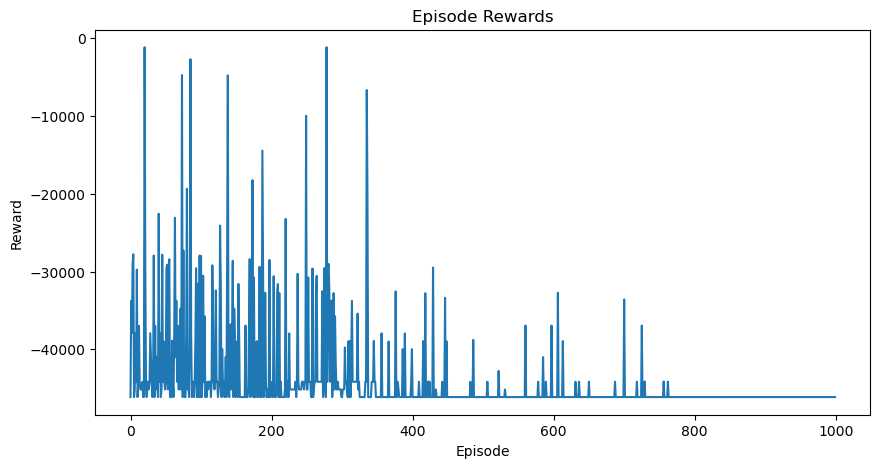

In [87]:
# Run the training and testing
if __name__ == "__main__":
    print("Starting DQN training...")
    agent, episode_rewards = train_dqn()

    # Plot training rewards
    plt.figure(figsize=(10, 5))
    plt.plot(episode_rewards)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.savefig(f"/scratch/gayathri.eee.nitt/routing/DQN/destination_wise_results_v1/reward_plots/reward-{date_string}-{destination_node}-{initial_SoC}.png")
    plt.show()

In [88]:
import os
from datetime import datetime
from io import StringIO
import sys
import matplotlib.pyplot as plt
import networkx as nx

# Function to test a single start_node
def test_dqn(agent, start_node, end_node=destination_node):
    current_node = start_node
    destination_node = end_node
    SoC = initial_SoC
    path = [current_node]
    total_time = 0
    total_price = 0
    steps = 0
    visited_nodes = set()
    charging_stations_visited = {}
    done = False
    success = False

    while not done and steps < max_steps_per_episode:
        state = get_state(current_node, SoC)

        if SoC <= 30 and not can_reach_destination(current_node, SoC, user_preference):
            action_layer2 = agent.choose_action_layer2(state, current_node, visited_nodes)
            next_node, SoC, _, time_taken_layer2, price, _ = step_layer2(
                action_layer2, current_node, SoC, path
            )
            total_time += time_taken_layer2
            total_price += price
            charging_stations_visited[action_layer2] = (time_taken_layer2, price)
        else:
            action_layer1 = agent.choose_action_layer1(state, current_node, visited_nodes)
            next_node, SoC, _, time_taken_layer1, done = step_layer1(
                action_layer1, current_node, SoC, visited_nodes, path
            )
            total_time += time_taken_layer1

        visited_nodes.add(current_node)
        current_node = next_node
        steps += 1

        if current_node == destination_node:
            done = True
            success = True

    result = []
    result.append(f"\n--- Test from Start Node {start_node} to Destination {destination_node} ---")
    result.append("Optimal Path: " + " -> ".join(map(str, path)))
    result.append(f"Total Time to Reach Destination: {total_time} minutes")
    result.append(f"Total Price to Reach Destination: {total_price} units")
    
    # Print results
    print("\nTest Results:")
    print("Optimal Path:", path)
    print("Total Time to Reach Destination:", total_time, "minutes")
    print("Total Price to Reach Destination:", total_price, "units")

    if charging_stations_visited:
        print("Charging Stations Visited, Time Spent, and Price:")
        for station, (time_spent, price) in charging_stations_visited.items():
            print(f"Charging Station {station}: {time_spent} minutes, {price} units")
    else:
        print("No Charging Stations Visited.")

    # Plot the path for this test case
    plot_path(G, pos, path, charging_stations, start_node, destination_node, initial_SoC)

    if charging_stations_visited:
        result.append("Charging Stations Visited, Time Spent, and Price:")
        for station, (time_spent, price) in charging_stations_visited.items():
            result.append(f"  Charging Station {station}: {time_spent} minutes, {price} units")
    else:
        result.append("No Charging Stations Visited.")
    
    result.append(f"Success: {'Yes' if success else 'No'}")
    return "\n".join(result), success

def plot_path(G, pos, path, charging_stations, start_node, destination_node, initial_SoC):
    """
    Plots the network with charging stations and highlights the optimal path for a specific test case.
    Saves the plot to a file.
    """
    plt.figure(figsize=(10, 10))
    
    # Define node colors (blue for regular nodes)
    node_colors = ['blue' for n in G.nodes]
    
    # Draw the graph with node labels
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color=node_colors,
                     arrows=True, arrowsize=20, node_size=800,
                     font_color='white', font_size=14)

    # Draw edge labels (weights)
    edge_labels = {(u, v): f"{d['length']:.2f}" for u, v, d in G.edges(data=True) if 'length' in d}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Highlight the optimal path in green
    path_edges = list(zip(path[:-1], path[1:]))  # Extract edges from path
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="green", width=3, alpha=0.8, label="Optimal Path")
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=900, node_color="green", edgecolors="black")
    
    # Highlight start and end nodes
    nx.draw_networkx_nodes(G, pos, nodelist=[start_node], node_size=1000, node_color="brown", edgecolors="black")
    nx.draw_networkx_nodes(G, pos, nodelist=[destination_node], node_size=1000, node_color="purple", edgecolors="black")

    # Highlight charging stations with red squares using plt.scatter
    for node in charging_stations:
        plt.scatter(pos[node][0], pos[node][1], s=1200, c='none', edgecolors='red', linewidths=5, marker='s')

    # Legend
    plt.scatter([], [], c='red', label='Charging Station', s=200, marker='s')
    plt.scatter([], [], c='blue', label='Regular Node', s=200)
    plt.scatter([], [], c='brown', label='Start Node', s=200)
    plt.scatter([], [], c='purple', label='Destination Node', s=200)
    plt.plot([], [], color="green", linewidth=3, label="Optimal Path")  # Line for path in legend
    plt.legend(loc='upper right', fontsize=12)

    # Title and layout
    plt.title(f'Optimal Path from {start_node} to {destination_node} (Initial SoC: {initial_SoC})', fontsize=14)
    
    # Create directory if it doesn't exist
    plot_dir = "/scratch/gayathri.eee.nitt/routing/DQN/destination_wise_results_v1/path_plots"
    os.makedirs(plot_dir, exist_ok=True)
    
    # Save the plot
    plot_filename = f"path_{start_node}_to_{destination_node}_SoC_{initial_SoC}_{date_string}.png"
    plot_path = os.path.join(plot_dir, plot_filename)
    plt.savefig(plot_path)
    plt.close()
    print(f"Saved plot to {plot_path}")

# Run tests for all start nodes (except the destination) and save all results into a single file
def run_all_tests_and_save(agent, destination_node, initial_SoC):
    save_path = f"/scratch/gayathri.eee.nitt/routing/DQN/destination_wise_results_v1/results_graph"
    os.makedirs(save_path, exist_ok=True)
    file_path = os.path.join(save_path, f"Results-{date_string}-{destination_node}-{initial_SoC}.txt")

    all_results = []
    success_count = 0
    tested_nodes = 0

    for node in range(1,25):
        if node == destination_node:
            continue
        result, success = test_dqn(agent, start_node=node, end_node=destination_node)
        all_results.append(result)
        tested_nodes += 1
        if success:
            success_count += 1

    # Calculate success rate
    success_rate = (success_count / tested_nodes) * 100
    summary = f"\n\n--- Summary ---\nTotal Tested Nodes: {tested_nodes}\nSuccessful Routes: {success_count}\nSuccess Rate: {success_rate:.2f}%"
    all_results.append(summary)

    # Combine all results and write to file
    final_output = "\n\n".join(all_results)

    with open(file_path, 'w') as f:
        f.write(final_output)

    # Print the results here
    print(final_output)

# Example usage:
run_all_tests_and_save(agent, destination_node, initial_SoC)


Test Results:
Optimal Path: [2, 6, 5, 9, 10, 15]
Total Time to Reach Destination: 153.33333333333334 minutes
Total Price to Reach Destination: 0 units
Charging Stations Visited, Time Spent, and Price:
Charging Station 7: 0 minutes, 0 units
Saved plot to /scratch/gayathri.eee.nitt/routing/DQN/destination_wise_results_v1/path_plots/path_2_to_1_SoC_70_2025-04-25_07-56-46.png

Test Results:
Optimal Path: [3, 4, 5, 6, 2, 1]
Total Time to Reach Destination: 140.0 minutes
Total Price to Reach Destination: 0 units
No Charging Stations Visited.
Saved plot to /scratch/gayathri.eee.nitt/routing/DQN/destination_wise_results_v1/path_plots/path_3_to_1_SoC_70_2025-04-25_07-56-46.png

Test Results:
Optimal Path: [4, 5, 6, 2, 1]
Total Time to Reach Destination: 113.33333333333334 minutes
Total Price to Reach Destination: 0 units
No Charging Stations Visited.
Saved plot to /scratch/gayathri.eee.nitt/routing/DQN/destination_wise_results_v1/path_plots/path_4_to_1_SoC_70_2025-04-25_07-56-46.png

Test Resu

Saved plot to /scratch/gayathri.eee.nitt/routing/DQN/destination_wise_results_v1/path_plots/path_24_to_1_SoC_70_2025-04-25_07-56-46.png

--- Test from Start Node 2 to Destination 1 ---
Optimal Path: 2 -> 6 -> 5 -> 9 -> 10 -> 15
Total Time to Reach Destination: 153.33333333333334 minutes
Total Price to Reach Destination: 0 units
Charging Stations Visited, Time Spent, and Price:
  Charging Station 7: 0 minutes, 0 units
Success: No


--- Test from Start Node 3 to Destination 1 ---
Optimal Path: 3 -> 4 -> 5 -> 6 -> 2 -> 1
Total Time to Reach Destination: 140.0 minutes
Total Price to Reach Destination: 0 units
No Charging Stations Visited.
Success: Yes


--- Test from Start Node 4 to Destination 1 ---
Optimal Path: 4 -> 5 -> 6 -> 2 -> 1
Total Time to Reach Destination: 113.33333333333334 minutes
Total Price to Reach Destination: 0 units
No Charging Stations Visited.
Success: Yes


--- Test from Start Node 5 to Destination 1 ---
Optimal Path: 5 -> 6 -> 2 -> 1
Total Time to Reach Destination:

In [89]:
import shutil

# Path to the folder you want to zip
folder_path = '/scratch/gayathri.eee.nitt/routing/DQN/destination_wise_results_v1'
# Path to the zip file (you can rename it as needed)
zip_path = '/scratch/gayathri.eee.nitt/routing/DQN/destination_wise_results_v1.zip'

# Create a zip file
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)


'/scratch/gayathri.eee.nitt/routing/DQN/destination_wise_results_v1.zip'